## COSI Temperature correction: manually fitting temperature-binned energy spectra
- Obtain temperatures and energies from data collected over a wide range of temperatures.
- Bin the data by temperature and create one spectrum per bin. 
- Make a plot of peak center energy vs. temperature with a fit for each temperature bin (similar to Carolyn's method but with more points and with energy instead of ADC)

NOTE: 
I use energy instead of ADC here because I'm making one plot for an entire data run, i.e. finding one relationship between peak center and temperature for data collected by all detectors simultaneously. Each strip has a different gain and energy calibration, so a combined spectra plotted in ADC units containing events from all detectors will appear broaded, nonsensical. The peaks will not be resolved. 

So, this is NOT a strip-by-strip calibration like Carolyn did. Because Carolyn looked at each strip individually, she could make plots for each strip in terms of ADC vs. temperature.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
# Convert ADC to energy via the provided energy calibration .ecal file
def d_model(ecal):
    file_object = open(str(ecal),"r")
    lines = file_object.readlines()
    model = []; d = {}
    
    for line in lines:
        if line.startswith("CP"):
            det = line.split()[2]; strip = line.split()[3]; side = line.split()[4] 
            key = det+" "+strip+" "+side
        
        if line.startswith("CM"):
            if key in line:
                model = [float(x) for x in line.split()[6:]]
                max_num_coeffs = 5
                if len(model) < max_num_coeffs:
                    model.extend([0]*(max_num_coeffs - len(model)))

                if len(model) > max_num_coeffs:
                    print("You're using a calibration model with more than 5 coefficients. Code isn't updated for that yet. Sorry.")
                d[key] = model
    return d


In [3]:
# Parse an .roa file from a calibration run. Save the energy and temperature of each event. 
def parse_roa(roa,d,e_min,e_max):
    file_object = open(str(roa),"r")
    lines = file_object.readlines()
    
    energies = []
    temp = []
    
    for i in range(len(lines)):
        line = lines[i]
        if line.startswith("UH") and len(line.split()) >= 7:
            det = line.split()[1]; strip = line.split()[2]; side = line.split()[3] 
            key = det+" "+strip+" "+side
            adc = float(line.split()[4])
            #timing = line.split()[5]
            temperature = float(line.split()[6])

            if key not in d.keys():
                continue

            model = d[key]
            energy = model[0] + model[1]*adc + model[2]*adc**2 + model[3]*adc**3 + model[4]*adc**4

            if (energy > e_min and energy < e_max):
                energies.append(energy)
                temp.append(temperature)

    return energies,temp


In [4]:
ecal_file = "/home/jacqueline/nuclearizer/resource/calibration/COSI20/Wanaka/ecal_Wanaka2020_201005.ecal"
e_min = 0
e_max = 2000

# Na-22

In [5]:
roa_path = "/volumes/eos/users/jacqueline/EnergyCalib_Wanaka2020/Na22/"
roa_file = ["BD_COSI_GCUcalib-200314_050200-200314_194000-Na22split.roa00","BD_COSI_GCUcalib-200314_050200-200314_194000-Na22split.roa01","BD_COSI_GCUcalib-200314_050200-200314_194000-Na22split.roa02"]
d = d_model(ecal_file)

energies = []
temp = []
for i in roa_file:
    print(i)
    roa = roa_path + i
    e,t = parse_roa(roa,d,e_min,e_max)
    energies.extend(e)
    temp.extend(t)

print("Minimum energy [keV]:",min(energies),"Maximum energy [keV]:",max(energies))
print("Minimum temp [C]:",min(temp),"Maximum temp [C]:",max(temp))

BD_COSI_GCUcalib-200314_050200-200314_194000-Na22split.roa00
BD_COSI_GCUcalib-200314_050200-200314_194000-Na22split.roa01
BD_COSI_GCUcalib-200314_050200-200314_194000-Na22split.roa02
Minimum energy [keV]: 14.078481234483199 Maximum energy [keV]: 1999.7753655731099
Minimum temp [C]: 30.1917 Maximum temp [C]: 34.3924


In [6]:
df = pd.DataFrame({'Energy':energies,'PreampTemp':temp})

### Define temperature bins

In [7]:
# There are len(temp_bins) temperature bin edges so there are len(temp_bins)-1 temperature bins

temp_bin_width = 0.35
#temp_bins = np.arange(int(df["PreampTemp"].min()),int(df["PreampTemp"].max()+temp_bin_width),temp_bin_width)

temp_bins = np.arange(df["PreampTemp"].min(),df["PreampTemp"].max()+temp_bin_width,temp_bin_width)
temp_bin_labels = [str(round(i,2)) for i in temp_bins]
print(temp_bins)
print(temp_bin_labels)

[30.1917 30.5417 30.8917 31.2417 31.5917 31.9417 32.2917 32.6417 32.9917
 33.3417 33.6917 34.0417 34.3917 34.7417]
['30.19', '30.54', '30.89', '31.24', '31.59', '31.94', '32.29', '32.64', '32.99', '33.34', '33.69', '34.04', '34.39', '34.74']


<h3>Use numpy.histogram2d which uses the PreampTemp and Energy entries as they are and bin them according to the binning in temperature and energy we define:</h3>

In [98]:
# Define energy bins

# # # 511 keV
energy_min = 200
energy_max = 800
energy_bins = np.linspace(energy_min,energy_max,1800)

energy = 510.99 # true keV


# # 1274 keV
# energy_min = 900
# energy_max = 1500
# energy_bins = np.linspace(energy_min,energy_max,1800)

# energy = 1274.58 # true keV

In [99]:
binned_data = np.histogram2d(df['Energy'].values,
                             df['PreampTemp'].values,
                             bins=(energy_bins,temp_bins))

<h5>All 1 spectra for the temperature ranges:</h5>

In [100]:
print(binned_data[0].shape)
print(binned_data[1].shape) # same as # of energy_bins
print(binned_data[2].shape) # same as # of temp_bins

(1799, 13)
(1800,)
(14,)


### Fit the peak
<h3>Add a straight line instead of an offset to have more flexibility:<br>
$f(x;a,x_0,\sigma,b,c) = a \cdot \exp\left(-\frac{1}{2}\frac{(x-x_0)^2}{2\sigma^2}\right) + b + c \cdot x$</h3>

In [101]:
# Define function to fit the peak
def gauss_line(x,a,x0,sigma,b,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b + c*x

In [102]:
# Define boolean to select photopeak
bool_peak = np.where((energy_bins >= 505) & (energy_bins <= 517))[0]
#bool_peak = np.where((energy_bins >= 1268) & (energy_bins <= 1280))[0]

# Fit the spectrum in each temperature bin
centers = (0.5*(energy_bins[0:-1] + energy_bins[1:]))

<h3>For the starting values of the fit, there are several possibilities:<br>
For a constant, we can just use the average of the first and last point of the spectrum.<br>
For a straight line, we can use the first and last point of the spectrum and calculate b and c by solving the two equations:<br>
    $y_1 = b + c \cdot x_1$<br>
    $y_2 = b + c \cdot x_2$<br>
    which gives:
    $c = \frac{y_2-y_1}{x_2-x_1}$<br>
    and<br>
    $b = y_1 - c \cdot x_1$</h3>

<h5>Example:</h5>

In [103]:
c_guess = (binned_data[0][bool_peak,1][-1]-binned_data[0][bool_peak,1][0])/\
          (centers[bool_peak][-1]-centers[bool_peak][0])

b_guess = binned_data[0][bool_peak,1][0] - c_guess * centers[bool_peak][0]

In [104]:
b_guess,c_guess

(20071.133333333448, -38.378666666666895)

<h3>For the Gaussian, if there is only one line we have to consider and can look at the spectrum first, we can read of the values. But if we want to do it over and over again for many spectra that we do not want to look at every time, we can also estimate a guess based on the raw data:<br>
    First we guess the amplitude by subtracting the straight line from the spectrum and find the maximum:<br>
    $a = \mathrm{max}(y-(b+c \cdot x))$.<br>
    This also gives the centroid $x_0$ by<br>
    $x_0 = x_{\mathrm{argmax}(y-(b+c \cdot x))}$</h3>

<h5>Example:</h5>

In [105]:
a_guess = np.max(binned_data[0][bool_peak,1] - (b_guess + c_guess*centers[bool_peak]))

x0_guess = centers[bool_peak][np.argmax(binned_data[0][bool_peak,1] - (b_guess + c_guess*centers[bool_peak]))]

In [106]:
a_guess,x0_guess

(5412.799999999999, 510.67259588660363)

<h3>The width can be approximated by knowing what the area $I$ of a Gaussian is:<br>
    $I = \sqrt{2\pi}a\sigma \leftrightarrow \sigma = \frac{I}{\sqrt{2\pi}a}$<br>
    We guessed $a$ so that we only need $I$ which we get by summing over all the counts of the data minus the straight line offset:<br>
    $I = \sum[y-(b+c \cdot x)]$, so that<br>
    $\sigma = \frac{\sum[y-(b+c \cdot x)]}{\sqrt{2\pi}a}$.</h3>

<h5>Example:</h5>

In [107]:
sigma_guess = np.sum(binned_data[0][bool_peak,1] - (b_guess + c_guess*centers[bool_peak]))/\
              (np.sqrt(2*np.pi)*a_guess)

sigma_guess

4.8348756008080125

<h3>And finally run the loop over the temperatures:<br>
    Note that curvefit assumes the error bars on the y-data to be 1.0 if not provided. We can (and should in this case) assign an errorbar as $\sqrt{y}$ in the call to the fit. Not is not entirely correct since counts don't have errors, but for this case, it should suffice.</h3>

In [108]:
### Define function to plot and fit spectra in each temperature bin, with or without corrected energies

def plot_fit_temp_spectra(temp_bin_labels,binned_data,centers,bool_peak,energy,correc=False,correc_params=None):
    
    # Initialize lists to store temperatures, mean peak value
    temp_list = [] 
    mean_list = []
    mean_err_list = []
    
    # filled if correc=True
    corrections = []

    nsubplots = len(temp_bin_labels)
    print(nsubplots)
    nc = 3
    #nr=2
    nr = nsubplots // nc + 1
    #nr += nsubplots % nc
    print(nr)
    #nr=3
    fig, ax = plt.subplots(nrows=nr,ncols=nc,figsize=(20,20))

#     for i in range(nr):
#         for j in range(nc):
    for i in range(nsubplots):  
        row = i//nc
        pos = i % nc
        # running index
        #ridx = i*4+j 
        #temp = temp_bin_labels[ridx]
        temp = temp_bin_labels[i]
        if temp==temp_bin_labels[-1]:
            continue
        temp_list.append(temp) # representative for the bin

        # tmp data to not have needlessly large indexing
        #tmp_y = np.copy(binned_data[0][bool_peak,ridx])
        tmp_y = np.copy(binned_data[0][bool_peak,i])
        tmp_x = np.copy(centers[bool_peak])
        
        #############################
        if correc == True:

            # Apply linear correction
            slope = correc_params[0]/energy;offset = correc_params[1]/energy
            mod = slope*float(temp)+offset
            #print("slope:",slope,"offset:",offset,"temp:",temp,"mod:",mod)
            tmp_x = tmp_x/mod
            #print("newenergy:",tmp_x)
            
            correction = 1./mod
            corrections.append(correction)
        #############################

        # guesses:
        c_guess = (tmp_y[-1]-tmp_y[0])/(tmp_x[-1]-tmp_x[0])

        b_guess = tmp_y[0] - c_guess * tmp_x[0]

        a_guess = np.max(tmp_y - (b_guess + c_guess*tmp_x))

        x0_guess = tmp_x[np.argmax(tmp_y - (b_guess + c_guess*tmp_x))]

        sigma_guess = np.sum(tmp_y - (b_guess + c_guess*tmp_x))/(np.sqrt(2*np.pi)*a_guess)

        # guess array for curvefit
        p0 = [a_guess,x0_guess,sigma_guess,b_guess,c_guess]
        # note the sigma here
        popt,pcov = curve_fit(gauss_line,tmp_x,tmp_y,sigma=np.sqrt(tmp_y),p0=p0)
        x_fit = np.linspace(energy-15,energy+15,500)

#         ax[i,j].step(tmp_x,tmp_y,where='mid',color='black',label='data')
#         ax[i,j].plot(x_fit,gauss_line(x_fit,*popt),label='fit',color='red')
#         ax[i,j].set_title("{}-{} C".format(temp_bin_labels[ridx],temp_bin_labels[ridx+1]))

        ax[row,pos].step(tmp_x,tmp_y,where='mid',color='black',label='data')
        ax[row,pos].plot(x_fit,gauss_line(x_fit,*popt),label='fit',color='red')
        ax[row,pos].set_title("{}-{} C".format(temp_bin_labels[i],temp_bin_labels[i+1]))

        mean = popt[1]; mean_err = np.sqrt(pcov[1,1])
        mean_list.append(mean); mean_err_list.append(mean_err) 
        sigma = popt[2]; sigma_err = np.sqrt(pcov[2,2])
        
    return temp_list,mean_list,mean_err_list,corrections

In [109]:
### Define function to plot the centers from each fit against temperature

def plot_center_vs_temp_scatter(temp_bin_centers,mean_list,mean_err_list,source,correc=False):
    plt.figure(figsize=(8,7))

    # or should I be plotting against temp_list_<source>?
#     plt.errorbar(temp_bin_centers,mean_list_corr_Cs,
#              xerr=np.repeat(0.5,len(temp_bin_centers)),yerr=mean_err_list_corr_Cs,
#              fmt='.',color='k')
    plt.errorbar(temp_bin_centers,mean_list,
                 xerr=np.repeat(temp_bin_width/2,len(temp_bin_centers)),yerr=mean_err_list,
                 fmt='.',color='k')

    def linear(x,a,b):
        return a*x + b

    a_guess = -1
    b_guess = temp_bin_centers[0]

    p0 = [a_guess,b_guess]
    popt,pcov = curve_fit(linear,temp_bin_centers,mean_list,sigma=np.sqrt(mean_list),p0=p0)
    x_fit = np.linspace(min(temp_bin_centers)-1, max(temp_bin_centers)+1, 100)

    slope = popt[0];offset = popt[1]
    slope_err = np.sqrt(pcov[0,0]);offset_err=np.sqrt(pcov[1,1])
    

    plt.plot(x_fit,linear(x_fit,*popt),label='Fit: E = ({} $\pm$ {})T + {} $\pm$ {}'
             .format("%.2f"%slope,"%.2f"%slope_err,"%.1f"%offset,"%.1f"%offset_err),color='red')
    plt.legend(loc='best',fontsize=14)
    
    
    # disable scientific notation on axes
  #  plt.ticklabel_format(style="plain",useOffset=False)
    
    plt.xlabel("Temperature [$^\circ$C]",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
#     # disable scientific notation on axes
#     plt.ticklabel_format(style="plain",useOffset=False)
    
    if correc==True:
        plt.ylabel("Corrected peak energy [keV]",fontsize=14)
        #plt.title("Corrected {} peak energy vs. Temperature".format(source),fontsize=14)
        plt.savefig('/volumes/eos/users/jacqueline/EnergyRes_Wanaka2020/CrossTalkCorrection_rofl/TempCorr2020_Na22_511keV_centroids_corrected.pdf', bbox_inches='tight')

    else:
        plt.ylabel("Peak energy [keV]",fontsize=14)
        #plt.title(" {} peak energy vs. Temperature".format(source),fontsize=14)
        plt.savefig('/volumes/eos/users/jacqueline/EnergyRes_Wanaka2020/CrossTalkCorrection_rofl/TempCorr2020_Na22_511keV_centroids.pdf', bbox_inches='tight')
        
    return slope,slope_err,offset,offset_err


14
5


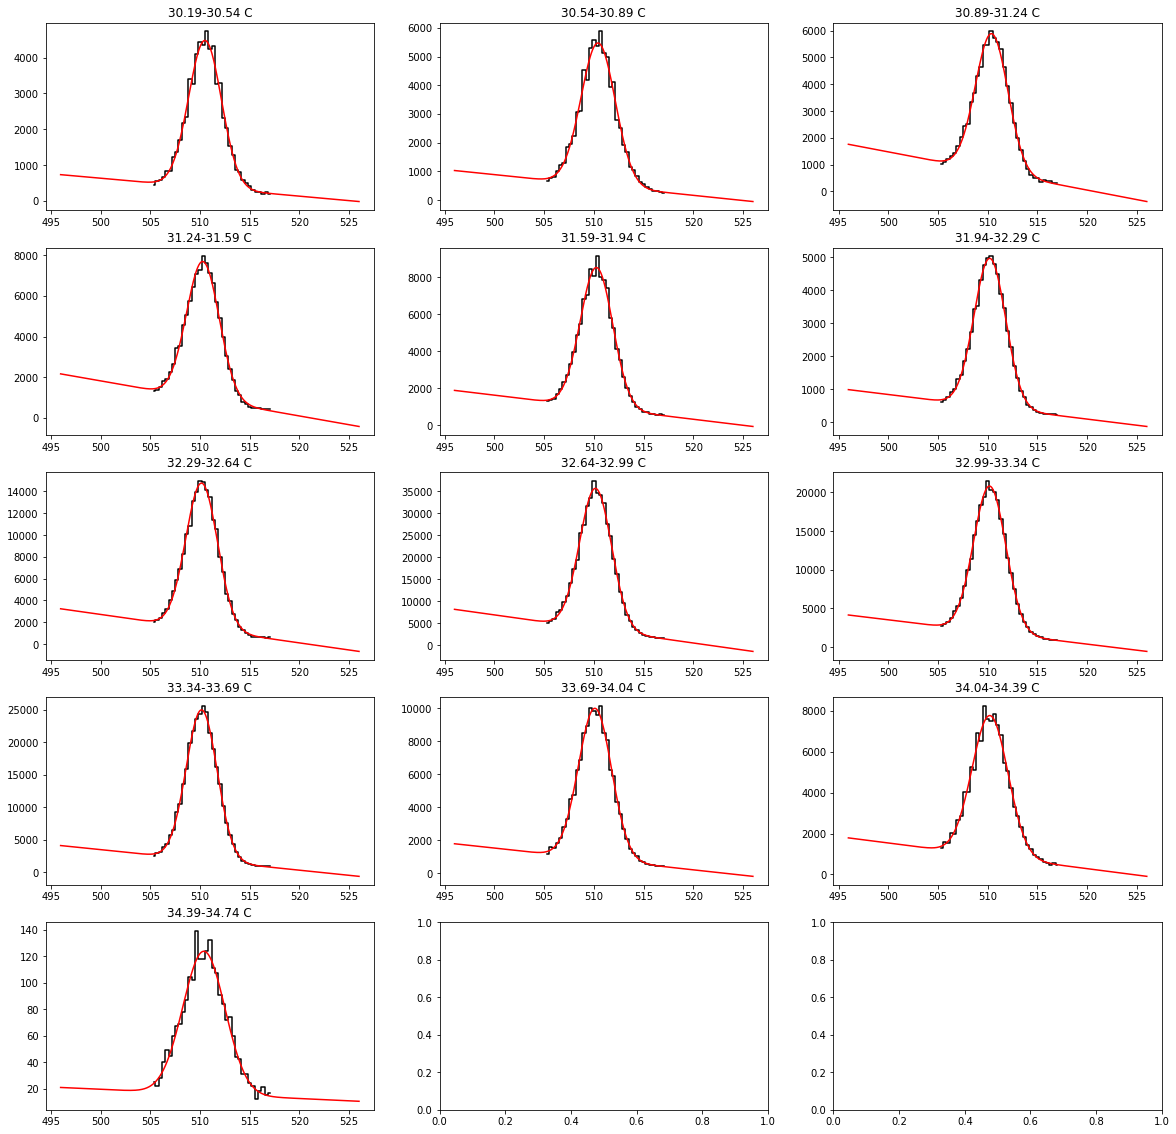

In [110]:
# Fit the temperature-binned peaks 
# temp_list,mean_list,mean_err_list,_ = plot_fit_temp_spectra(temp_bin_labels,binned_data,centers,bool_peak,energy)
temp_list,mean_list,mean_err_list,_ = plot_fit_temp_spectra(temp_bin_labels,binned_data,centers,bool_peak,energy)

<h5>The fits look reasonable. We could also calculate $\chi^2$ even though it is formally not correct.<br>
    The result is shown below: Not too much more information if we trust the error bar?</h5>

In [111]:
## Choose the mean between bin edges as representative for the temperature
#temp_bin_centers = 0.5*(temp_bins[0:-1]+temp_bins[1:])

temp_bin_centers = [0.5*(temp_bins[i]+temp_bins[i+1]) for i in range(len(temp_bins)-1)]
print(temp_bin_centers)

[30.3667, 30.716700000000003, 31.066700000000004, 31.416700000000006, 31.766700000000007, 32.11670000000001, 32.46670000000001, 32.81670000000001, 33.16670000000001, 33.516700000000014, 33.866700000000016, 34.21670000000002, 34.56670000000002]


[30.3667, 30.716700000000003, 31.066700000000004, 31.416700000000006, 31.766700000000007, 32.11670000000001, 32.46670000000001, 32.81670000000001, 33.16670000000001, 33.516700000000014, 33.866700000000016, 34.21670000000002, 34.56670000000002]


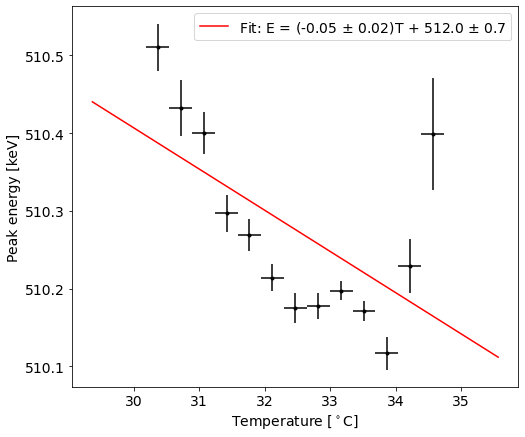

In [112]:
## Plot the centers of each fit against temperature

# manually remove bad fits

# 1274 keV
# unwanted = [1, -1] 
# print(temp_bin_centers)
# for ele in sorted(unwanted, reverse = True):  
#     del temp_bin_centers[ele]
#     del mean_list[ele]
#     del mean_err_list[ele]
print(temp_bin_centers)
slope,slope_err,offset,offset_err = plot_center_vs_temp_scatter(temp_bin_centers,mean_list,mean_err_list,source="Na-22",correc=False)
#nu


## Correct the spectra with Carolyn's "0th order correction"
#### Carolyn had a linear fit in terms of ADC vs. Temperature since she was fitting strip-by-strip. She included the linear fit in the energy calibration. The fit was 

measured ADC = slope*temp + offset. (page ~90s of notebook 14)

On page 106 of notebook 14, she also talks about a "0th order correction" that applied the same conversion to every strip:
Energy true = Energy_measured/shift(temp) = Energy_measured / (slope*temp + offset)

#### Repeat the above but correct the energy, as Carolyn did in her 0th order correction

-0.05298597150607289 511.99635254395616
0.021770771172434613 0.7074035610435551
14
5


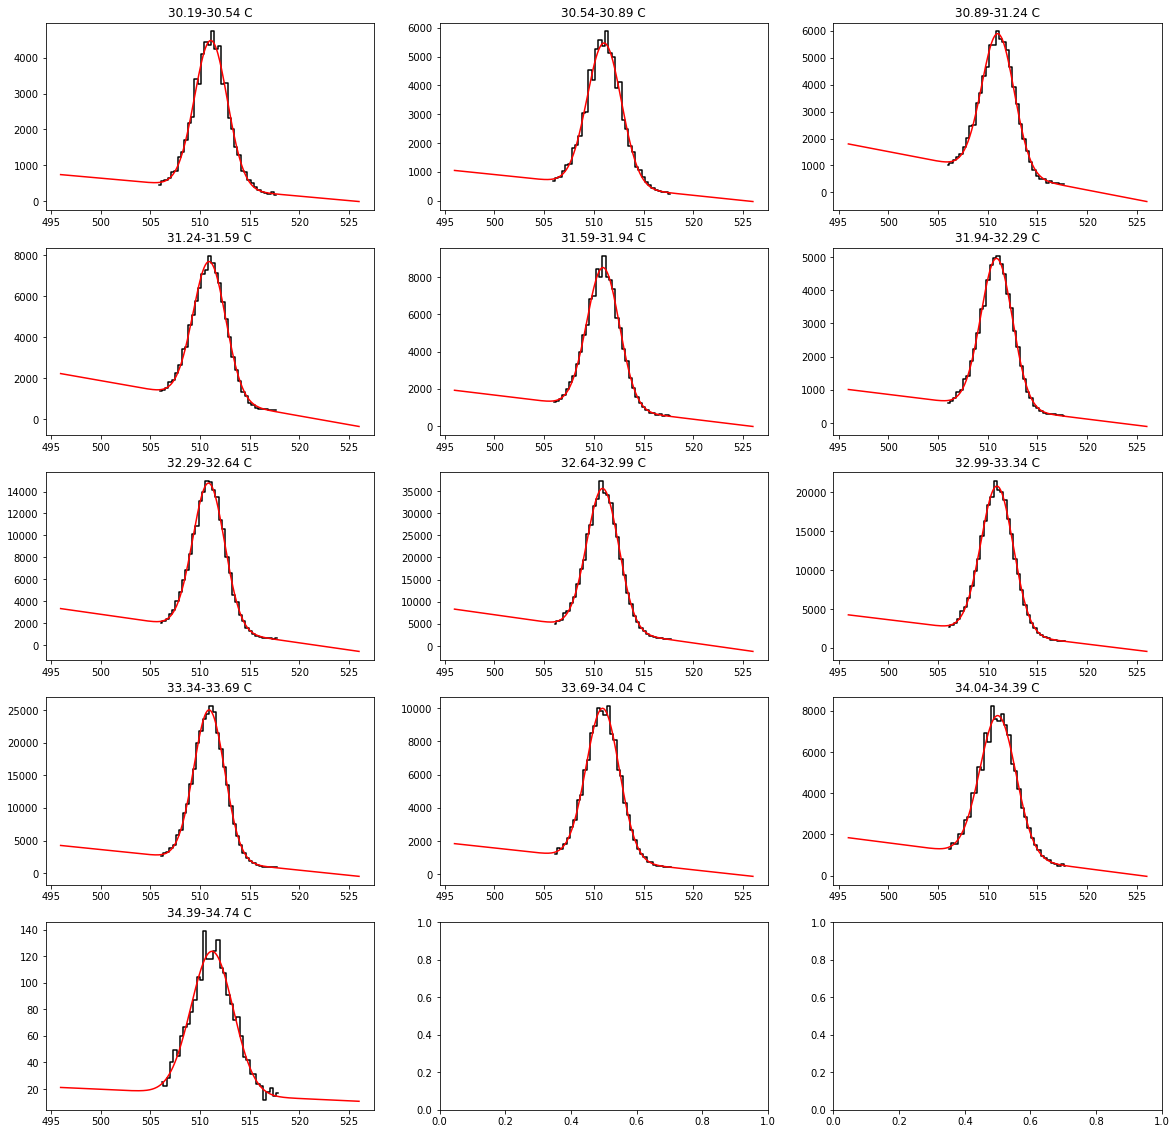

In [113]:
print(slope,offset)
print(slope_err,offset_err)
# Fit the temperature-binned peaks with corrected energies
temp_list_corr,mean_list_corr,mean_err_list_corr,corrections = plot_fit_temp_spectra(temp_bin_labels,
                                                                                                 binned_data,centers,bool_peak,energy,
                                                                                                 correc=True,correc_params=[slope,offset])

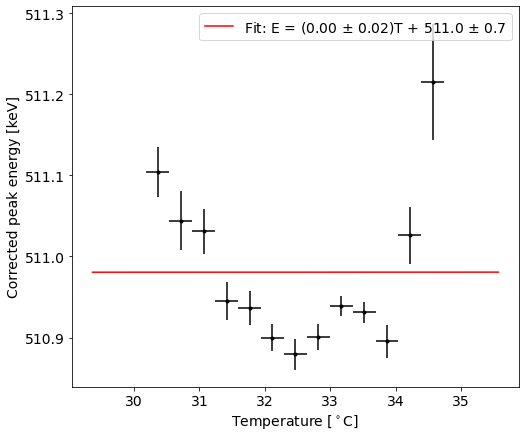

In [114]:
# manually remove bad fits
#unwanted_corr = [11,12] 

# # 1274 keV
# unwanted_corr = [1, -1] 

# #for ele in sorted(unwanted_corr, reverse = True):
# for ele in sorted(unwanted, reverse = True):
#     #del temp_bin_centers[ele]
#     del temp_list_corr[ele]
#     del mean_list_corr[ele]
#     del mean_err_list_corr[ele]

## Plot the centers of each corrected fit against temperature
slope_corr,slope_err_corr,offset_corr,offset_err_corr = plot_center_vs_temp_scatter(temp_bin_centers,mean_list_corr,mean_err_list_corr,source="Na-22",correc=True)


### Generate a temperature correction text file to give nuclearizer
This text file is modeled off of Carolyn's temperature correction CT files:
CT dss det strip side P0 P1
, where energy_corrected = energy_old * P1 + P0

P1 = slope_Co / true Co energy

P0 = offset_Co / true Co energy

I wrote "write_CT.py" to write a line of the above form for each strip using the same P0 and P1, i.e. the 0th order correction.

In [ ]:
#f = open("/volumes/eos/users/jacqueline/EnergyRes_Wanaka2020/CrossTalkCorrection_rofl/Na22/temp_corr/TempCalibration_Na22_511keV_200816.txt","w")
# f = open("/volumes/eos/users/jacqueline/EnergyRes_Wanaka2020/CrossTalkCorrection_rofl/Na22/temp_corr/TempCalibration_Na22_1274keV_200816.txt","w")

# num_dets = 12
# num_strips = 37
# num_sides = 2

# P1 = slope / energy
# P0 = offset / energy

# for det in range(num_dets):
#     for side in range(num_sides):
#         for strip in range(1,num_strips+1):
#             f.write("CT dss "+str(det)+" "+str(strip)+" "+str(side)+" "+str(P0)+" "+str(P1))
#             f.write("\n")
# f.close()